# HR Analytics: Understanding Employee Attrition
Analyzing trends and patterns in employee attrition using HR analytics data from Kaggle. The data is on Atlas Lab's employees. [HR Analytics Employee Attrition and Performance] (https://www.kaggle.com/datasets/mahmoudemadabdallah/hr-analytics-employee-attrition-and-performance/data)

## Objectives
- Understand the distribution of employee attributes (age, department, role, etc.)
- Explore patterns in employee attrition
- Analyze job and performance satisfaction metrics
- Identify factors correlated with attrition

In [50]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, normaltest, probplot
from univariate import ql_stats, dt_stats
from bivariate import nparametric_tests, interpret_results
import scipy.stats as stats



## Load and Clean Data
Load two datasets: **'employee.csv'** and **'performance.csv'**

In [51]:
df_employee = pd.read_csv('data/Employee.csv')
df_performance = pd.read_csv('data/PerformanceRating.csv')

In [52]:
df_employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   EmployeeID               1470 non-null   object
 1   FirstName                1470 non-null   object
 2   LastName                 1470 non-null   object
 3   Gender                   1470 non-null   object
 4   Age                      1470 non-null   int64 
 5   BusinessTravel           1470 non-null   object
 6   Department               1470 non-null   object
 7   DistanceFromHome (KM)    1470 non-null   int64 
 8   State                    1470 non-null   object
 9   Ethnicity                1470 non-null   object
 10  Education                1470 non-null   int64 
 11  EducationField           1470 non-null   object
 12  JobRole                  1470 non-null   object
 13  MaritalStatus            1470 non-null   object
 14  Salary                   1470 non-null  

In [53]:
df_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6709 entries, 0 to 6708
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   PerformanceID                    6709 non-null   object
 1   EmployeeID                       6709 non-null   object
 2   ReviewDate                       6709 non-null   object
 3   EnvironmentSatisfaction          6709 non-null   int64 
 4   JobSatisfaction                  6709 non-null   int64 
 5   RelationshipSatisfaction         6709 non-null   int64 
 6   TrainingOpportunitiesWithinYear  6709 non-null   int64 
 7   TrainingOpportunitiesTaken       6709 non-null   int64 
 8   WorkLifeBalance                  6709 non-null   int64 
 9   SelfRating                       6709 non-null   int64 
 10  ManagerRating                    6709 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 576.7+ KB


## df_employee & df_performance
- **df_employee** has 22 columns while df_performance has only 10
    - both have a common key, **"EmployeeID"**
    - amongst **df_employee**, it has numerical, categorical, datetime, and ordinal variables
    - **df_performance** only has ordinal, datetime, and one categorical variable
- while **df_employee** has 1470 entries, df_performance has 6709
    - **df_performance** has more entries due to there being multiple review dates for some employees
    - during these reviews, they recorded their satisfaction and ratings related to the company and their work

In [54]:
# change ReviewDate to datetime
df_performance["ReviewDate"] = pd.to_datetime(df_performance["ReviewDate"])
# sort performance by employee + review date
df_performance = df_performance.sort_values(["EmployeeID", "ReviewDate"])
# keep the most recent review for each employee
df_performance = df_performance.groupby("EmployeeID").tail(1)

Before merging, we should turn **ReviewDate** into a datetime variable. We also need to sort **df_performance** by oldest to newest review date, for each employee. This way, we only select the most recent review date for our cleaned dataset which gives us more insight for employee attrition.

In [55]:
df_hr_only = df_employee.copy()

df_with_reviews = pd.merge(df_employee, df_performance, on='EmployeeID', how='inner')

df_all = pd.merge(df_employee, df_performance, on='EmployeeID', how='left')

**df_hr_only** only contains data from df_employee, which contains 1470 employees

**df_with_reviews** contains data from both **df_employee** and **df_performance**, which contains only 1280 employees that have gone under review. 

**df_all** contains data all 1470 employees + the performance data, regardless if an employee has been reviewed before or not. It shows up as 190 missing data values, which means there are 190 employees who have not been reviwed yet.

Divided into 3 different datasets to see the effect of performance/reviews on employee attrition.

In [56]:
# map binary columns
cleaned_df = [df_hr_only, df_with_reviews, df_all]
for df in cleaned_df:
    df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
    df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

In [57]:
# mapping ordinal columns
satisfaction_map = {
    1: 'Very Dissatisfied',
    2: 'Dissatisfied',
    3: 'Neutral',
    4: 'Satisfied',
    5: 'Very Satisfied'
}

performance_map = {
    1: 'Unacceptable',
    2: 'Needs Improvement',
    3: 'Meets Expectations',
    4: 'Exceeds Expectation',
    5: 'Above and Beyond'
}

education_map = {
    1: 'No Formal Qualifications',
    2: 'High School',
    3: 'Bachelors',
    4: 'Masters',
    5: 'Doctorate'
}

# ensure Education is present for mapping
for df in cleaned_df:
    if 'Education' not in df.columns:
        # if somehow lost during merge, bring it from df_employee
        df = df.merge(df_employee[['EmployeeID', 'Education']], on='EmployeeID', how='left')

# define ordinal mappings by column
ordinal_mappings = {
    'EnvironmentSatisfaction': satisfaction_map,
    'JobSatisfaction': satisfaction_map,
    'RelationshipSatisfaction': satisfaction_map,
    'WorkLifeBalance': satisfaction_map,
    'SelfRating': performance_map,
    'ManagerRating': performance_map,
    'Education': education_map
}

# apply mappings
for col, mapping in ordinal_mappings.items():
    for df in cleaned_df:
        if col in df.columns:
            df[col] = df[col].map(mapping)
            df[col] = pd.Categorical(df[col], categories=list(mapping.values()), ordered=True)

Map binary columns: **OverTime** and **Attrition**
Map ordinal columns in cleaned_df: **EnvironmentSatisfaction**, **JobSatisfaction**, **RelationshipSatsifaction**, **WorkLifeBalance**, **SelfRating**, **ManagerRating** and **Education**.
- Each level can be found in "RatingLevel.csv", "EducationLevel.csv", and "SatisfiedLevel.csv".
- **StockOptionLevel** has no specific level mapping.
- **Education** and **StockOptionLevel** are the only ordinal variables in "Employee.csv"

In [58]:
# convert the rest of the categorical columns
categorical_cols = [ 
    'Gender', 'BusinessTravel', 'Department', 'State',
        'Ethnicity', 'EducationField', 
    'JobRole', 'MaritalStatus', 'StockOptionLevel']
for col in categorical_cols:
    for df in cleaned_df:
        df[col] = df[col].astype('category')

# make sure any date columns are in datetime
for df in cleaned_df:
    df['HireDate'] = pd.to_datetime(df['HireDate'])

# fix typos in EducationField
for df in cleaned_df:
    if 'EducationField' in df.columns:
        df['EducationField'] = df['EducationField'].str.strip().str.title()
        df['EducationField'] = df['EducationField'].replace({
            'Marketing ': 'Marketing',
            'Marketting': 'Marketing'
        })
# make sure EducationField is categorical
df['EducationField'] = df['EducationField'].astype('category')

The rest of the categorical variables are **Gender**, **BusinessTravel**, **Department**, **State**, **Ethnicity**, **EducationField**, **JobRole**, **MaritalStatus**, and **StockOptionLevel**.

In [59]:
# drop unused columns
df_hr_only = df_hr_only.drop(columns=['FirstName', "LastName", "EmployeeID"])

df_with_reviews = df_with_reviews.drop(columns=['FirstName', 'LastName', 'PerformanceID', "EmployeeID"])
df_all = df_all.drop(columns=['FirstName', 'LastName', 'PerformanceID', 'EmployeeID'])

In [60]:
df_hr_only.head()

,Gender,Age,BusinessTravel,Department,DistanceFromHome (KM),State,Ethnicity,Education,EducationField,JobRole,MaritalStatus,Salary,StockOptionLevel,OverTime,HireDate,Attrition,YearsAtCompany,YearsInMostRecentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Female,30,Some Travel,Sales,27,IL,White,Doctorate,Marketing,Sales Executive,Divorced,102059,1,0,2012-01-03,0,10,4,9,7
1,Male,38,Some Travel,Sales,23,CA,White,Masters,Marketing,Sales Executive,Single,157718,0,1,2012-01-04,0,10,6,10,0
2,Male,43,Some Travel,Human Resources,29,CA,Asian or Asian American,Masters,Marketing,HR Business Partner,Married,309964,1,0,2012-01-04,0,10,6,10,8
3,Non-Binary,39,Some Travel,Technology,12,IL,White,Bachelors,Computer Science,Engineering Manager,Married,293132,0,0,2012-01-05,0,10,10,10,0
4,Female,29,Some Travel,Human Resources,29,CA,White,High School,Technical Degree,Recruiter,Single,49606,0,0,2012-01-05,1,6,1,1,6


In [61]:
df_with_reviews.head()

,Gender,Age,BusinessTravel,Department,DistanceFromHome (KM),State,Ethnicity,Education,EducationField,JobRole,...,YearsWithCurrManager,ReviewDate,EnvironmentSatisfaction,JobSatisfaction,RelationshipSatisfaction,TrainingOpportunitiesWithinYear,TrainingOpportunitiesTaken,WorkLifeBalance,SelfRating,ManagerRating
0,Female,30,Some Travel,Sales,27,IL,White,Doctorate,Marketing,Sales Executive,...,7,2022-10-29,Satisfied,Dissatisfied,Satisfied,1,0,Dissatisfied,Above and Beyond,Exceeds Expectation
1,Male,38,Some Travel,Sales,23,CA,White,Masters,Marketing,Sales Executive,...,0,2022-07-29,Neutral,Satisfied,Satisfied,3,0,Dissatisfied,Above and Beyond,Exceeds Expectation
2,Male,43,Some Travel,Human Resources,29,CA,Asian or Asian American,Masters,Marketing,HR Business Partner,...,8,2022-04-07,Satisfied,Very Satisfied,Neutral,3,0,Satisfied,Exceeds Expectation,Meets Expectations
3,Non-Binary,39,Some Travel,Technology,12,IL,White,Bachelors,Computer Science,Engineering Manager,...,0,2022-03-26,Very Dissatisfied,Satisfied,Neutral,2,2,Neutral,Meets Expectations,Meets Expectations
4,Female,29,Some Travel,Human Resources,29,CA,White,High School,Technical Degree,Recruiter,...,6,2021-05-12,Neutral,Satisfied,Neutral,1,2,Very Satisfied,Meets Expectations,Needs Improvement


In [62]:
df_all.head()

,Gender,Age,BusinessTravel,Department,DistanceFromHome (KM),State,Ethnicity,Education,EducationField,JobRole,...,YearsWithCurrManager,ReviewDate,EnvironmentSatisfaction,JobSatisfaction,RelationshipSatisfaction,TrainingOpportunitiesWithinYear,TrainingOpportunitiesTaken,WorkLifeBalance,SelfRating,ManagerRating
0,Female,30,Some Travel,Sales,27,IL,White,Doctorate,Marketing,Sales Executive,...,7,2022-10-29,Satisfied,Dissatisfied,Satisfied,1.0,0.0,Dissatisfied,Above and Beyond,Exceeds Expectation
1,Male,38,Some Travel,Sales,23,CA,White,Masters,Marketing,Sales Executive,...,0,2022-07-29,Neutral,Satisfied,Satisfied,3.0,0.0,Dissatisfied,Above and Beyond,Exceeds Expectation
2,Male,43,Some Travel,Human Resources,29,CA,Asian or Asian American,Masters,Marketing,HR Business Partner,...,8,2022-04-07,Satisfied,Very Satisfied,Neutral,3.0,0.0,Satisfied,Exceeds Expectation,Meets Expectations
3,Non-Binary,39,Some Travel,Technology,12,IL,White,Bachelors,Computer Science,Engineering Manager,...,0,2022-03-26,Very Dissatisfied,Satisfied,Neutral,2.0,2.0,Neutral,Meets Expectations,Meets Expectations
4,Female,29,Some Travel,Human Resources,29,CA,White,High School,Technical Degree,Recruiter,...,6,2021-05-12,Neutral,Satisfied,Neutral,1.0,2.0,Very Satisfied,Meets Expectations,Needs Improvement


In [63]:
print(df_hr_only.isnull().sum())
print(df_with_reviews.isnull().sum())
print(df_all.isnull().sum())

Gender                     0
Age                        0
BusinessTravel             0
Department                 0
DistanceFromHome (KM)      0
State                      0
Ethnicity                  0
Education                  0
EducationField             0
JobRole                    0
MaritalStatus              0
Salary                     0
StockOptionLevel           0
OverTime                   0
HireDate                   0
Attrition                  0
YearsAtCompany             0
YearsInMostRecentRole      0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64
Gender                             0
Age                                0
BusinessTravel                     0
Department                         0
DistanceFromHome (KM)              0
State                              0
Ethnicity                          0
Education                          0
EducationField                     0
JobRole                            0
MaritalStatus                      0


Only **df_all** has 190 missing values. Meaning, there are 190 employees who do not have reviews yet. 

## 1. Exploratory Data Analysis - Univariate Variables
Observe any visible patterns we may want to look further into.
<br>Also check for distribution & normality.

- For categorical columns, print out the counts, percentages, unique categories, and most frequent value. Then print out a count plot for visualization.
- For numerical columns, print out summary, boxplot, mode, skewenss, kurtosis, histogram, QQ plot, and run a normality test.
- For datetime columns, print out the summary and print out a yearly count plot.

*all plots can be viewed in "plots"*

In [64]:
sns.set(style='whitegrid', palette='hls')
plt.rcParams['figure.figsize'] = (10, 6)



--- Categorical Summary: Attrition ---
           Count  Percentages
Attrition                    
0           1233        83.88
1            237        16.12
Unique categories: 2
Most frequent: 0


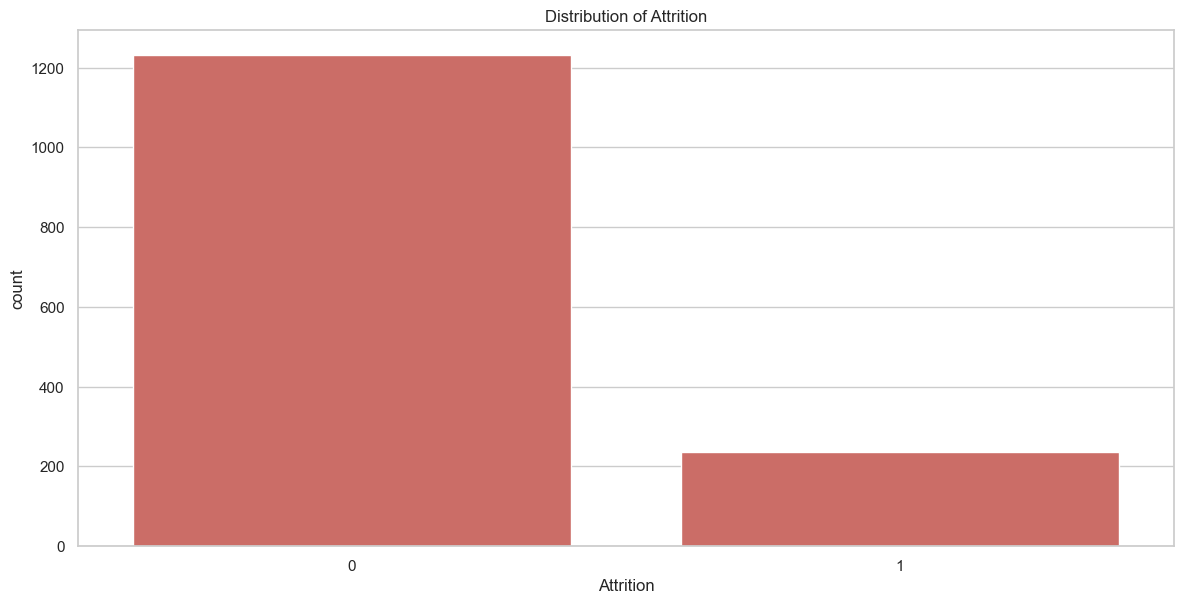

In [65]:

df = df_hr_only
ql_stats(df, 'Attrition')

Relating to turnover, we see 83.88% of non-attrition in employees, or 16.12% of attrition. This indicates that this company has a healthy or positive retention rate, as more than 75% of the company has stayed with the company so far.


--- Categorical Summary: Gender ---
                   Count  Percentages
Gender                               
Female               675        45.92
Male                 651        44.29
Non-Binary           124         8.44
Prefer Not To Say     20         1.36
Unique categories: 4
Most frequent: Female


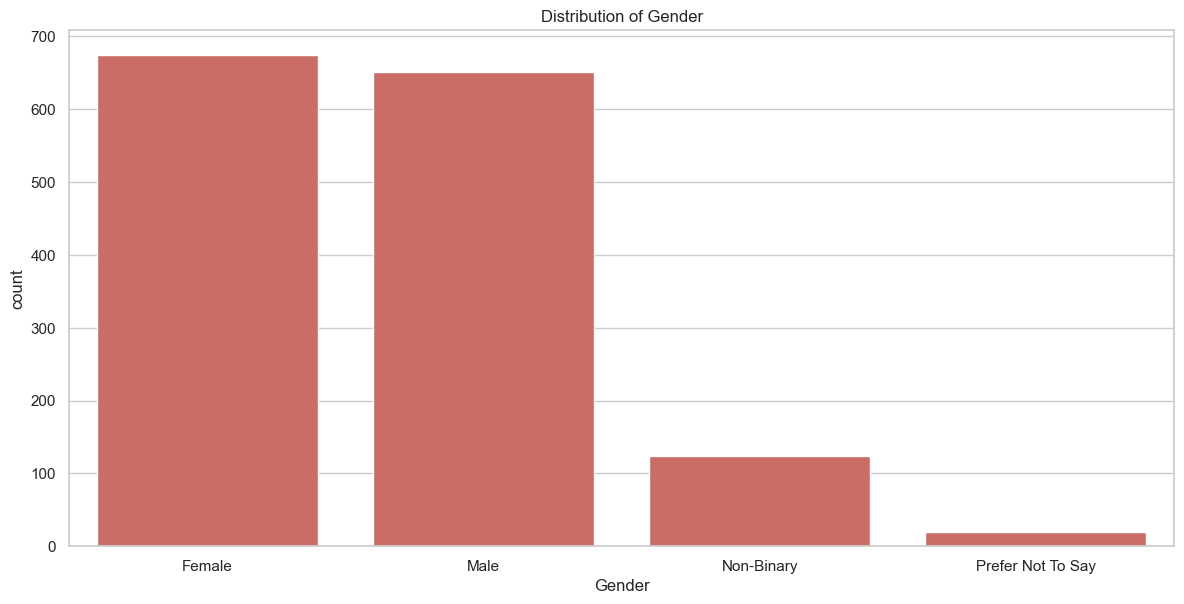

In [66]:
ql_stats(df, 'Gender')

Combined, 90.21% of the company identify as either **Female** or **Male**, with the most frequent gender being **Female** at 45.92%. Only 20 employees out of 1470 selected "Prefer Not To Say", making it the least frequent category. 

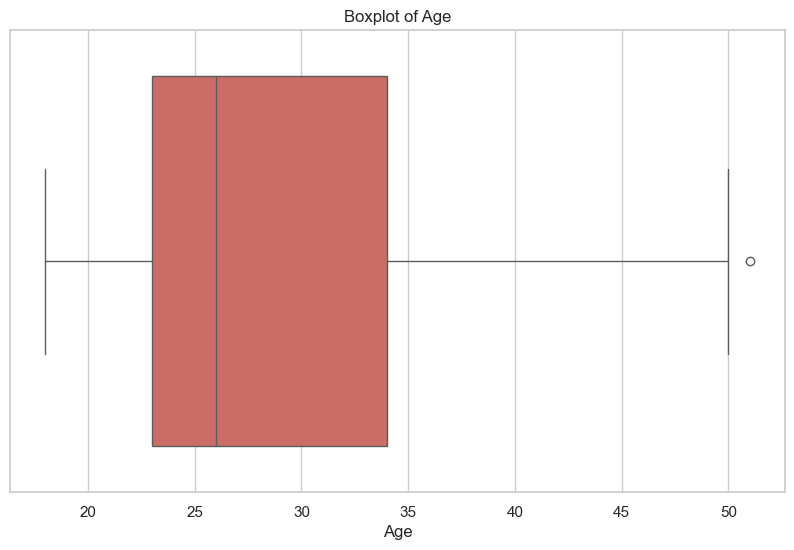

--- Numerical Summary: Age ---
count    1470.000000
mean       28.989796
std         7.993055
min        18.000000
25%        23.000000
50%        26.000000
75%        34.000000
max        51.000000
Name: Age, dtype: float64

Mode: 25
Skewness: 0.89
Kurtosis: 0.36


In [67]:
# boxplot
sns.boxplot(x=df['Age'])
plt.title("Boxplot of Age")
plt.xlabel('Age')
plt.show()

# summary
print("--- Numerical Summary: Age ---")
desc = df['Age'].describe()
print(desc)

# mode
print(f"\nMode: {df['Age'].mode()[0]}")
#skewness + kurtosis
print(f"Skewness: {skew(df['Age'].dropna()):.2f}")
print(f"Kurtosis: {kurtosis(df[col].dropna()):.2f}")


The average **age** is 28 years, with most of the employees being between 23 and 34 years old. The youngest employee is age 18, while the oldest is 51. Furthermore, the age distribution is right-skewed, with a larger concentration of younger employees. This suggest that the workforce is fairly young, with fewer employees being older than 35.

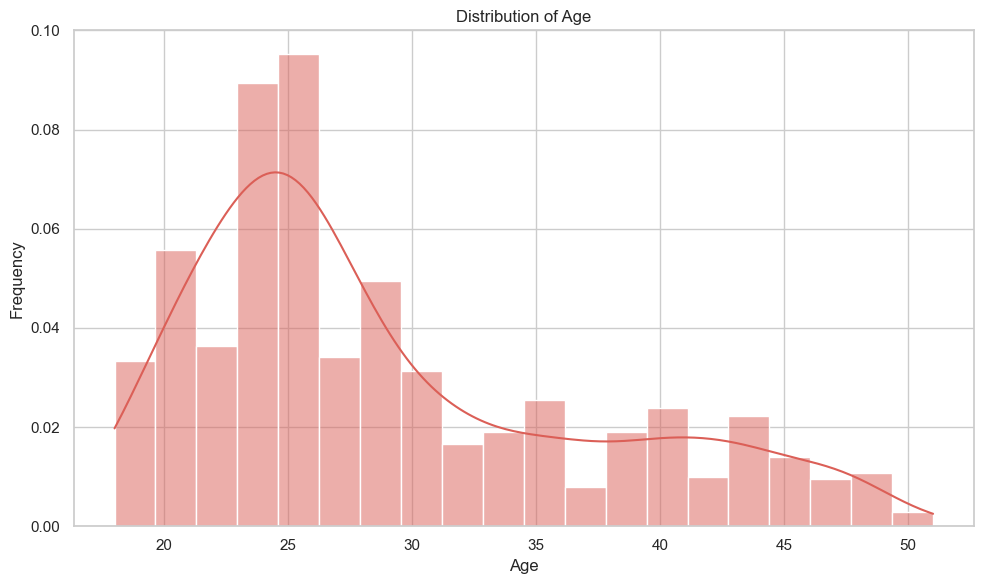


D'Agostino and Pearson Test:
Statistic = 151.4004, p-value = 0.0000
Data is not normally distributed.


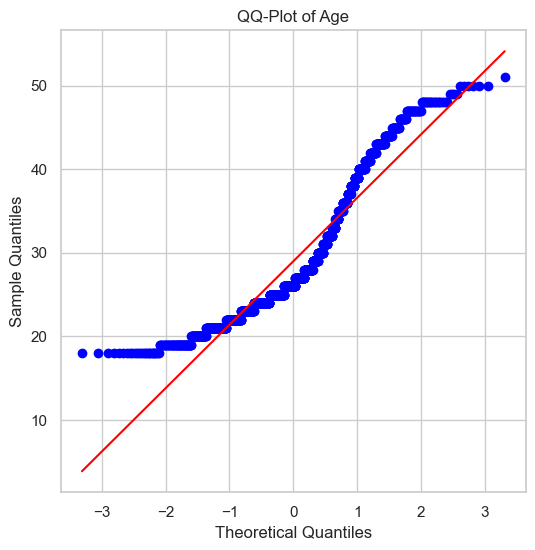

In [68]:
# histogram + kde
sns.histplot(df['Age'], kde=True, stat='density', bins=20)
plt.title("Distribution of Age")
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# normality test
stat, p=normaltest(df['Age'])
print(f"\nD'Agostino and Pearson Test:")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")
if p < 0.05: # 95% confidence
    print("Data is not normally distributed.")
else:
    print("Data is normally distributed.")

# QQ plot
plt.figure(figsize=(6,6))
probplot(df['Age'], dist='norm', plot=plt)
plt.title("QQ-Plot of Age")
plt.xlabel("Theoretical Quantiles")
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

The histogram with KDE and the QQ plot confirm that the age distributoin deviates from normality, showing a right-skew. Most employees are concentrated around their mid-20s, with a peak just above age 25. Beyond age 30, the number of employees gradually decreases and the distribution flattens, suggesting a relatively smaller but consistent precense of older employees. This pattern coild be due to higher attrition among older employees, or it may reflect the company's preference for hiring younger talent. Further analysis of age vs attrition rates and recruitment patterns may help clarify this trend.


--- Categorical Summary: BusinessTravel ---
                    Count  Percentages
BusinessTravel                        
Some Travel          1043        70.95
Frequent Traveller    277        18.84
No Travel             150        10.20
Unique categories: 3
Most frequent: Some Travel


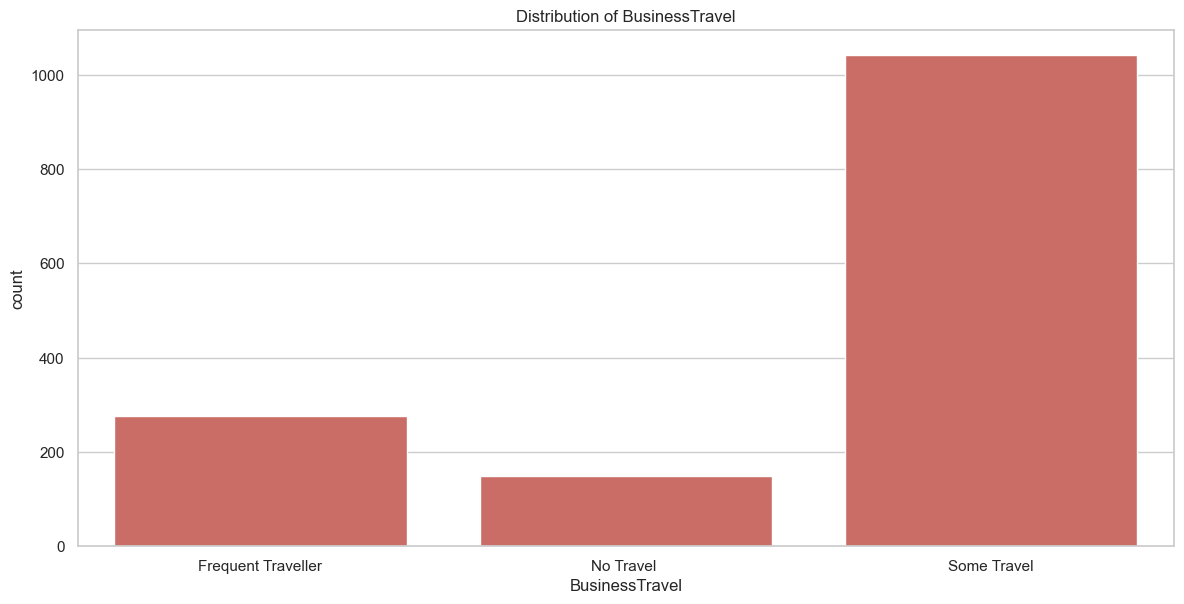

In [69]:
ql_stats(df, 'BusinessTravel')

The amount of business travel that is the most common is "Some Travel", at a percentage of 70.95%. The other options are "Frequent Traveler" and "No Travel", which have substantially lower counts. It can be inferred that while frequent traveling may not be required by the company, employees are still required to travel occasionally. For the employees who do not travel, it can be due to job role, or distance from work. However, we would need to investigate this further to see why.


--- Categorical Summary: Department ---
                 Count  Percentages
Department                         
Technology         961        65.37
Sales              446        30.34
Human Resources     63         4.29
Unique categories: 3
Most frequent: Technology


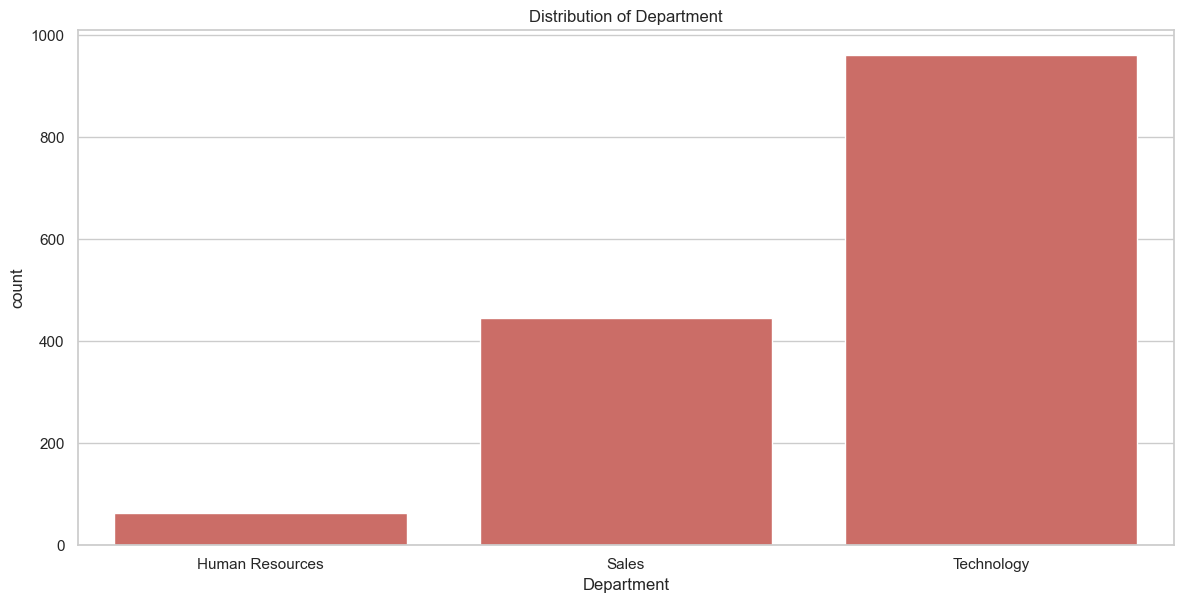

In [70]:
ql_stats(df, 'Department')

The two most biggest departments in terms of employee size are Sales and Technology. A little more than half of employees work in Technology. About half of the employees who work in Technology, work in Sales, at 30.34%. Only 63 out of 1470 employees work in Human Resources. It can be inferred that the company mainly focuses on the Technology and Sales departments. Also related to Departments, is Education Field and Job Role. 

/var/folders/m4/yjvjdcbn13v_8w2jnkcpn2jr0000gn/T/ipykernel_77640/1745440171.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/var/folders/m4/yjvjdcbn13v_8w2jnkcpn2jr0000gn/T/ipykernel_77640/1745440171.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


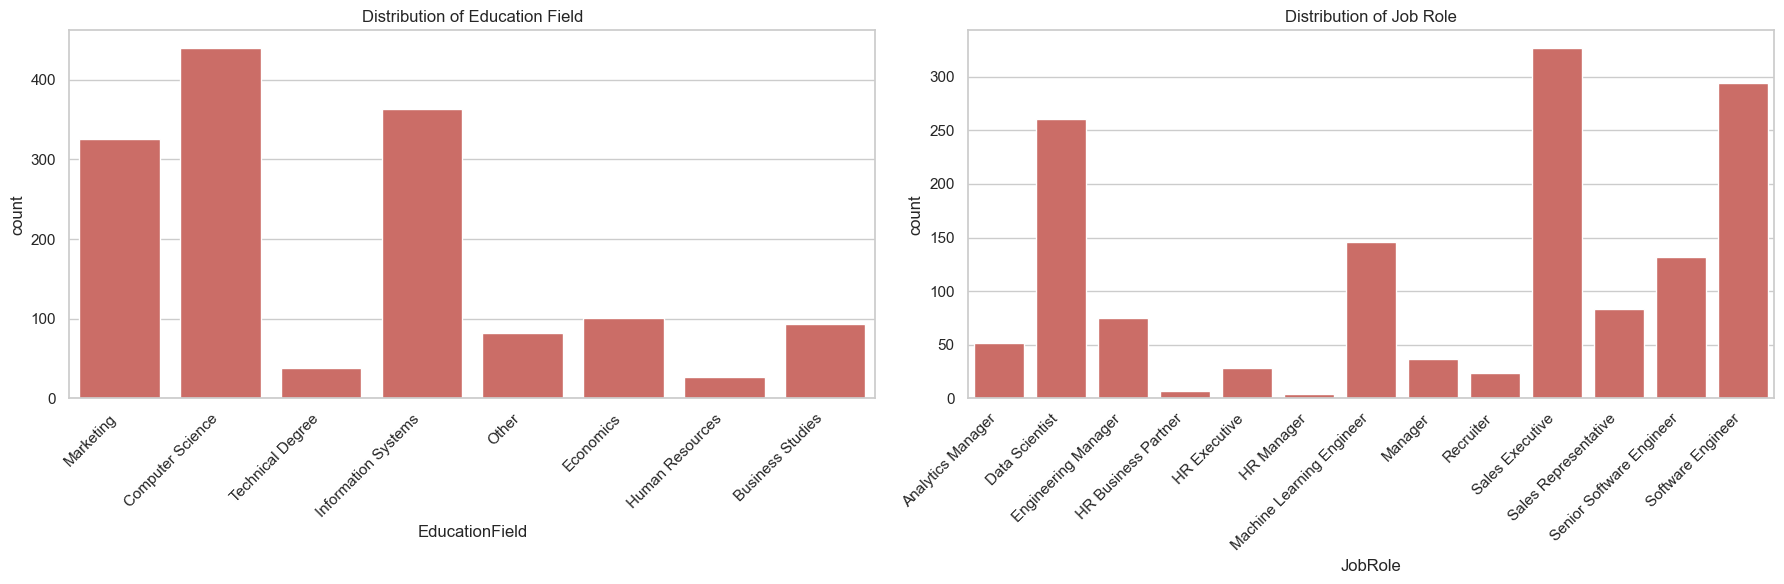


--- Categorical Summary: Education Field ---
                     Count  Percentages
EducationField                         
Computer Science       440        29.93
Information Systems    363        24.69
Marketing              325        22.11
Economics              101         6.87
Business Studies        94         6.39
Other                   82         5.58
Technical Degree        38         2.59
Human Resources         27         1.84
Unique categories: 8
Most frequent: Computer Science

--- Categorical Summary: Job Role ---
                           Count  Percentages
JobRole                                      
Sales Executive              327        22.24
Software Engineer            294        20.00
Data Scientist               261        17.76
Machine Learning Engineer    146         9.93
Senior Software Engineer     132         8.98
Sales Representative          83         5.65
Engineering Manager           75         5.10
Analytics Manager             52         3.54
Ma

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(x='EducationField', data=df, ax=ax1)
ax1.set_title('Distribution of Education Field')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

sns.countplot(x='JobRole', data=df, ax=ax2)
ax2.set_title('Distribution of Job Role')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

counts = df['EducationField'].value_counts(dropna=False)
percentages = df['EducationField'].value_counts(normalize=True, dropna=False) * 100
print("\n--- Categorical Summary: Education Field ---")
summary = pd.DataFrame({
    'Count': counts,
    'Percentages': percentages.round(2)
})
print(summary)
print(f"Unique categories: {df['EducationField'].nunique(dropna=False)}")
print(f"Most frequent: {df['EducationField'].mode()[0]}")

counts = df['JobRole'].value_counts(dropna=False)
percentages = df['JobRole'].value_counts(normalize=True, dropna=False) * 100
print("\n--- Categorical Summary: Job Role ---")
summary = pd.DataFrame({
    'Count': counts,
    'Percentages': percentages.round(2)
})
print(summary)
print(f"Unique categories: {df['JobRole'].nunique(dropna=False)}")
print(f"Most frequent: {df['JobRole'].mode()[0]}")

As you can see, the most frequent Education Fields for employees are Computer Science, Information Systems, and Marketing, while the most frequent Job Roles are Sales Executive, Software Engineering, and Data Scientist.


--- Categorical Summary: State ---
       Count  Percentages
State                    
CA       875        59.52
NY       419        28.50
IL       176        11.97
Unique categories: 3
Most frequent: CA


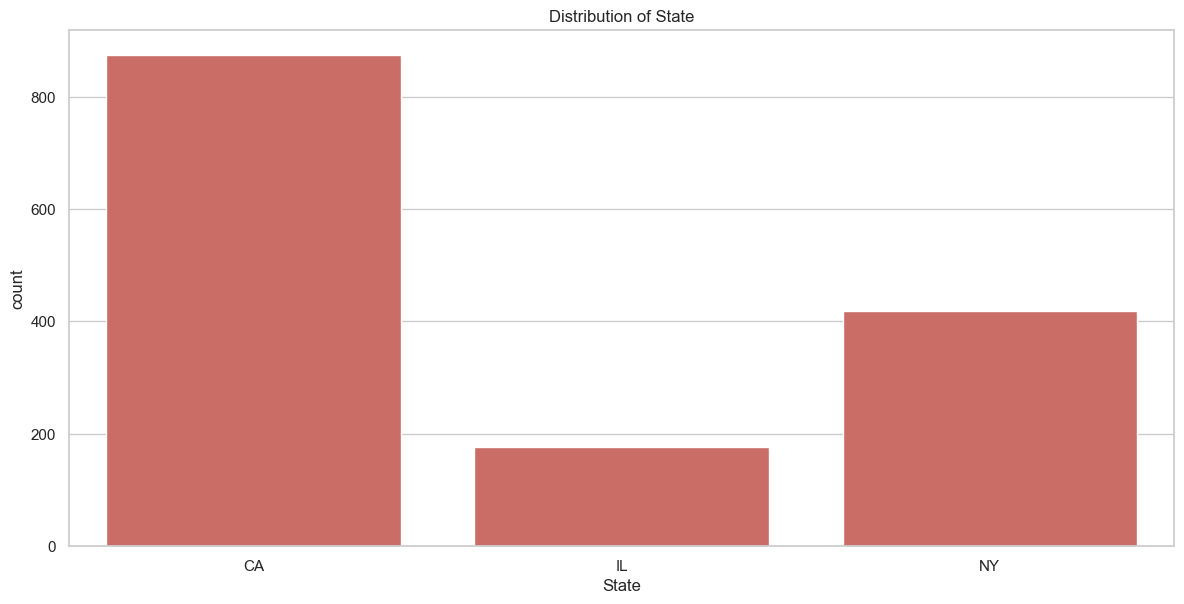

In [72]:
ql_stats(df, 'State')

59.52% of employees reside in California, while 28.50% in New York, and 11.97% in Illnois. This could be due to smaller offices around NY and IL, while most of the company could be CA based, with their larger offices located there. Because there are only 3 states that were reported in this dataset, it suggests that this company requires employees to work onsite. If the company was mostly remote, we might see a more broader range of states in this dataset.

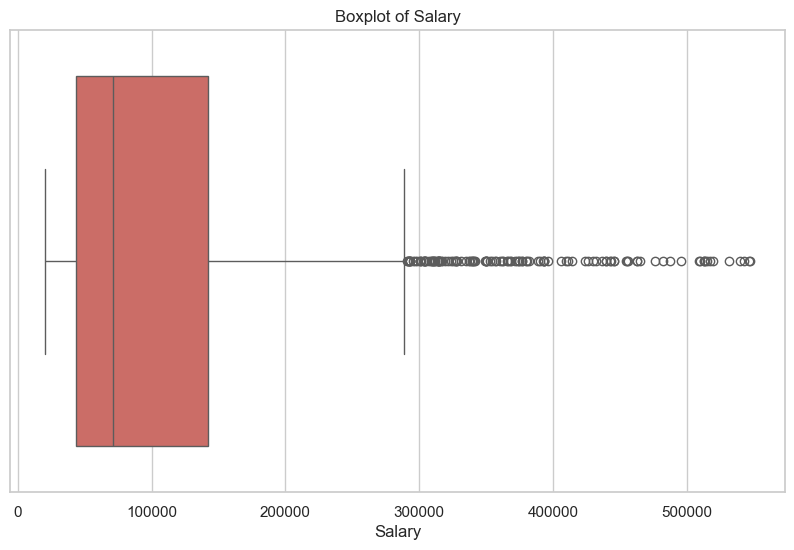

--- Numerical Summary: Salary ---
count      1470.000000
mean     112956.497959
std      103342.889222
min       20387.000000
25%       43580.500000
50%       71199.500000
75%      142055.750000
max      547204.000000
Name: Salary, dtype: float64

Mode: 26973
Skewness: 1.78
Kurtosis: 2.92


In [73]:
# boxplot
sns.boxplot(x=df['Salary'])
plt.title("Boxplot of Salary")
plt.xlabel('Salary')
plt.show()

# summary
print("--- Numerical Summary: Salary ---")
desc = df['Salary'].describe()
print(desc)

# mode
print(f"\nMode: {df['Salary'].mode()[0]}") 
# skewness + kurtosis
print(f"Skewness: {skew(df['Salary'].dropna()):.2f}")
print(f"Kurtosis: {kurtosis(df['Salary'].dropna()):.2f}")

Since the boxplot is right-skewed, we can see most of the data clustering over to the left side, meaning that most employees are paid a lower salary between $43,580 - $142,056. We also have a higher kurtosis, which can be seen by the boxplot's heavier tails with more extreme outliers. This indicates that it's extremely less common for an employee to have an extremely high salary at this company. 

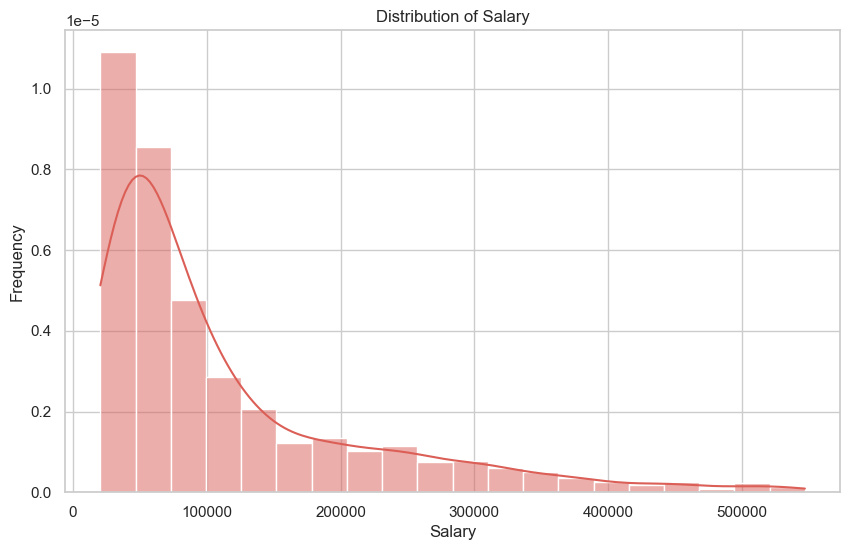

In [74]:
# histogram + kde
sns.histplot(df['Salary'], kde=True, stat='density', bins=20)
plt.title("Distribution of Salary")
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()


Like the boxplot suggested, the histogram shows a higher density of employees that earn a lower wage, and a very long right-tail that decreases as the salary rises. It indicates that the company pays most of their employees at a lower salary wage, with rare cases of paying other employees, a higher wage.


--- Categorical Summary: StockOptionLevel ---
                  Count  Percentages
StockOptionLevel                    
0                   631        42.93
1                   596        40.54
2                   158        10.75
3                    85         5.78
Unique categories: 4
Most frequent: 0


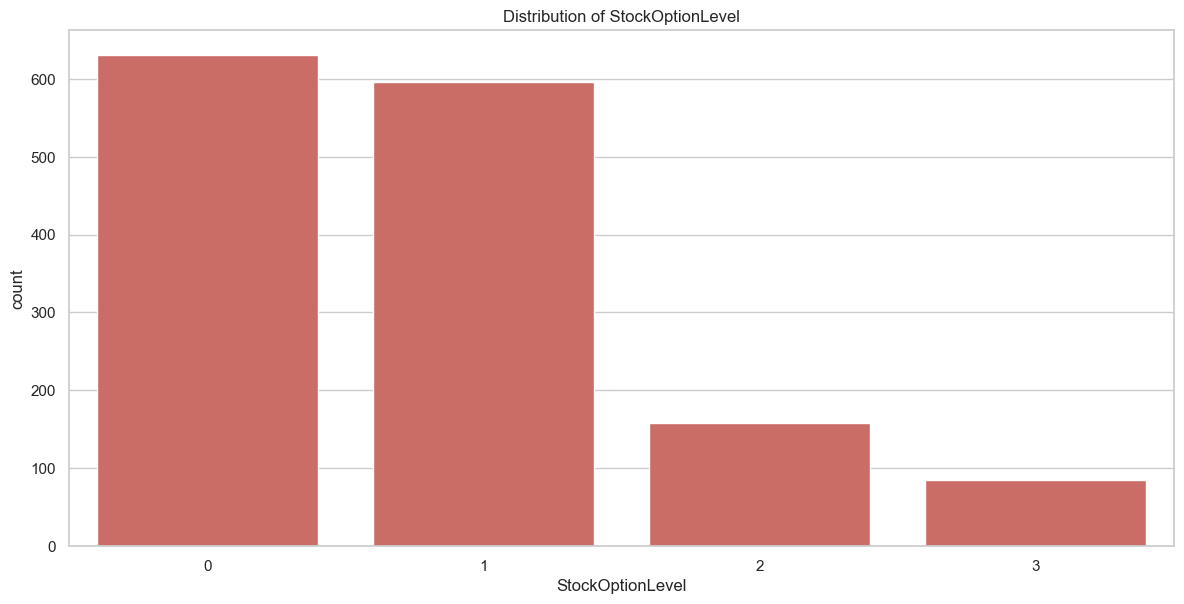

In [75]:
ql_stats(df, 'StockOptionLevel')

The Stock Option Level given to employees the most are Stock Level 0 (42.93%) and Level 1 (40.54%). The rest of the Stock Option Levels (2 and 3) are given out to fewer employees, which indicates that more generous stock options are reserved for a smaller portion of the workforce, likely those in higher positions or with longer tenure.


--- Categorical Summary: OverTime ---
          Count  Percentages
OverTime                    
0          1054         71.7
1           416         28.3
Unique categories: 2
Most frequent: 0


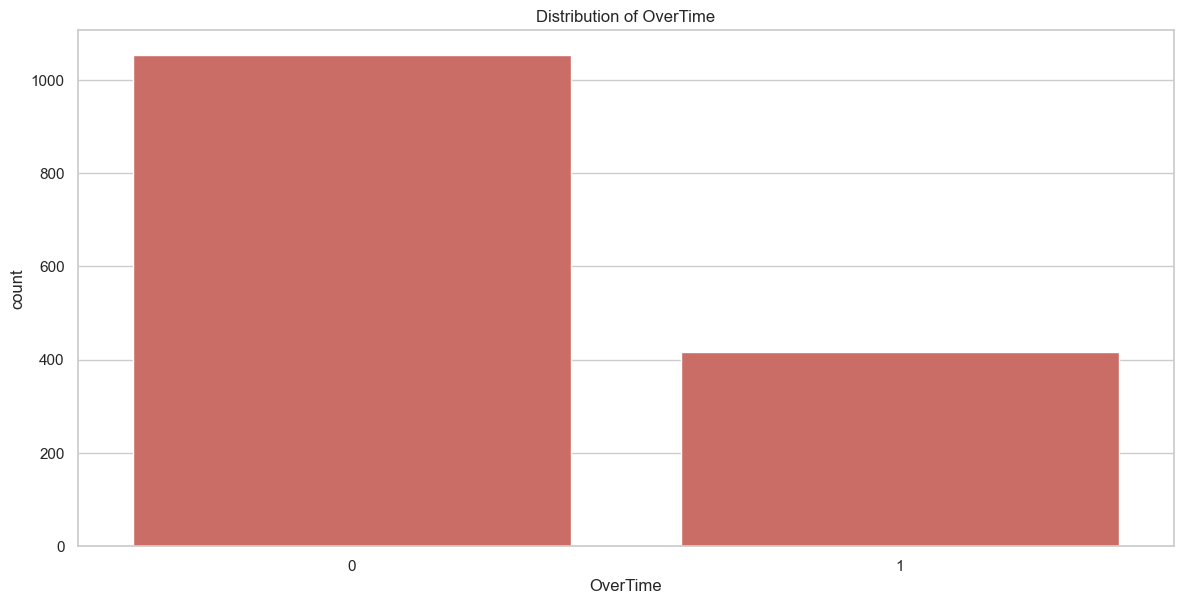

In [76]:
ql_stats(df, 'OverTime')

71.7% of employees do not work Overtime, while 28.3% do. It implies that the vast of employees are not required or strongly influenced to work extended hours. For the employees who do work overtime, it could be due to outside influences or due to job role.


--- Datetime Summary: HireDate ---
Min date: 2012-01-03 00:00:00
Max date: 2022-12-31 00:00:00
Range: 4015 days 00:00:00
Median: 2017-09-02 00:00:00
Mode: 2012-01-19 00:00:00
Unique dates: 1192

Counts per year:
HireDate
2012    151
2013    136
2014    136
2015    127
2016    114
2017    106
2018    136
2019    145
2020    127
2021    137
2022    155
Name: count, dtype: int64


/Users/emilynguyen/Documents/hr_analytics/univariate.py:157: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dt_yearly = df.set_index(col).resample('Y').size()


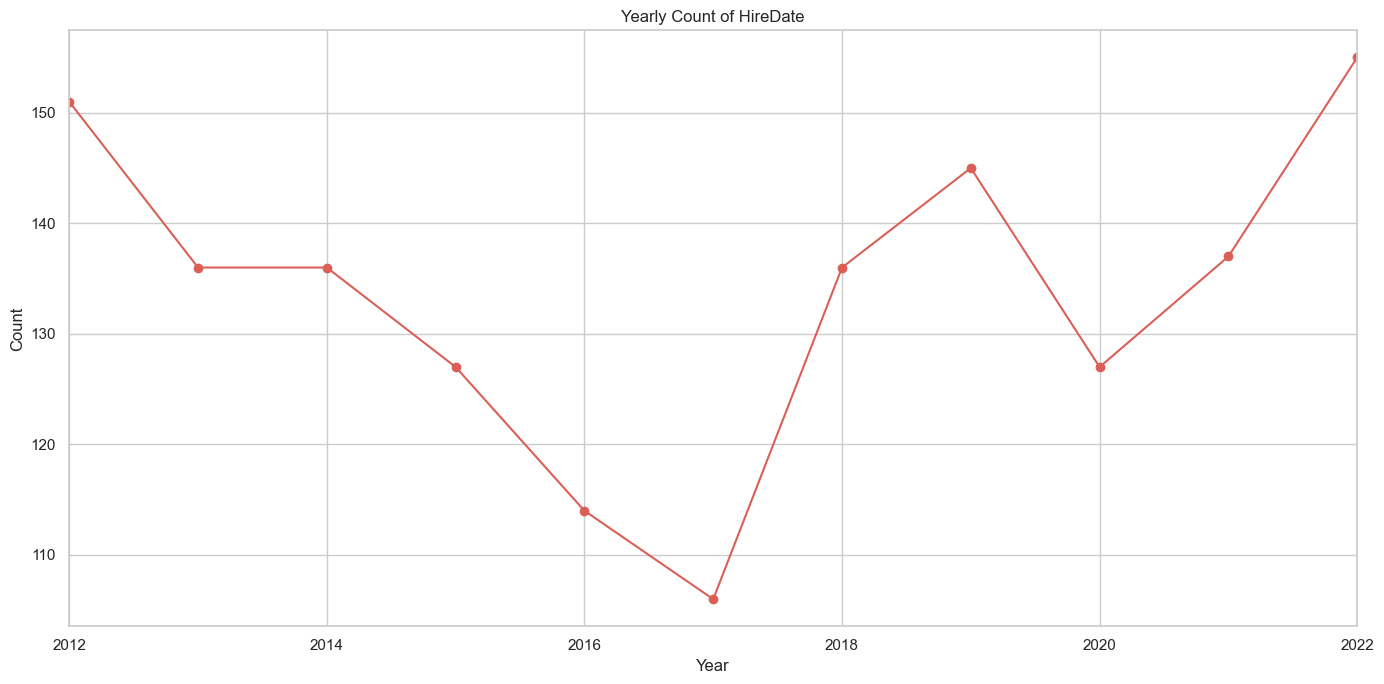

In [77]:
dt_stats(df, 'HireDate')

The first employee was hired on January 3rd, 2012, while the most recent hire was on December 31st, 2022, indicating that the company has been operating for nearly a decade. From 2012, hiring gradually decreased, suggesting fewer open positions or a smaller workforce in the early years. Around 2017-2018, the company saw a sharp increase in hires, with 136 new employees in 2018, likely due to expansion or higher turnover. In 2020, hiring slowed, likely impacted by the COVID-19 pandemic. After 2020, the number of new hires steadily increased, matching 155 in 2022, surpassing the initial hiring surge when the company first started.

/var/folders/m4/yjvjdcbn13v_8w2jnkcpn2jr0000gn/T/ipykernel_77640/516526288.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dt_yearly1 = df.set_index('HireDate').resample('Y').size()
/var/folders/m4/yjvjdcbn13v_8w2jnkcpn2jr0000gn/T/ipykernel_77640/516526288.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dt_yearly2 = df_with_reviews.set_index('HireDate').resample('Y').size()


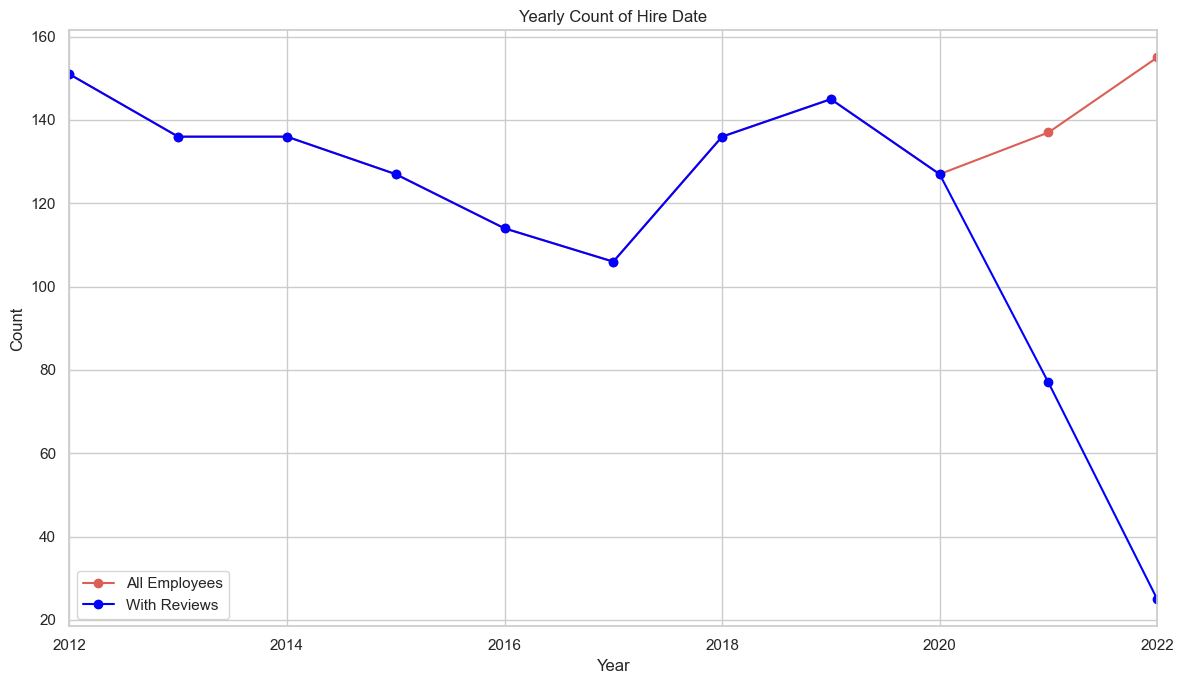

In [78]:
dt_yearly1 = df.set_index('HireDate').resample('Y').size()
dt_yearly2 = df_with_reviews.set_index('HireDate').resample('Y').size()

plt.figure(figsize=(12, 7))

# plot all employees
dt_yearly1.plot(marker='o', label='All Employees')

# plot employees with reviews
dt_yearly2.plot(marker='o', label='With Reviews', color='blue')

plt.title("Yearly Count of Hire Date")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Compared to the dataset containing only employees with reviews, the hires after 2020 appear to decrease sharply. This graph is one of the few where the review-only dataset noticably diverges from the full dataset.

/Users/emilynguyen/Documents/hr_analytics/univariate.py:157: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dt_yearly = df.set_index(col).resample('Y').size()



--- Datetime Summary: ReviewDate ---
Min date: 2013-04-23 00:00:00
Max date: 2022-12-31 00:00:00
Range: 3539 days 00:00:00
Median: 2022-05-18 12:00:00
Mode: 2022-05-22 00:00:00
Unique dates: 494

Counts per year:
ReviewDate
2013       2
2014       7
2015       9
2016       7
2017      14
2018      17
2019      18
2020      27
2021      54
2022    1125
Name: count, dtype: int64


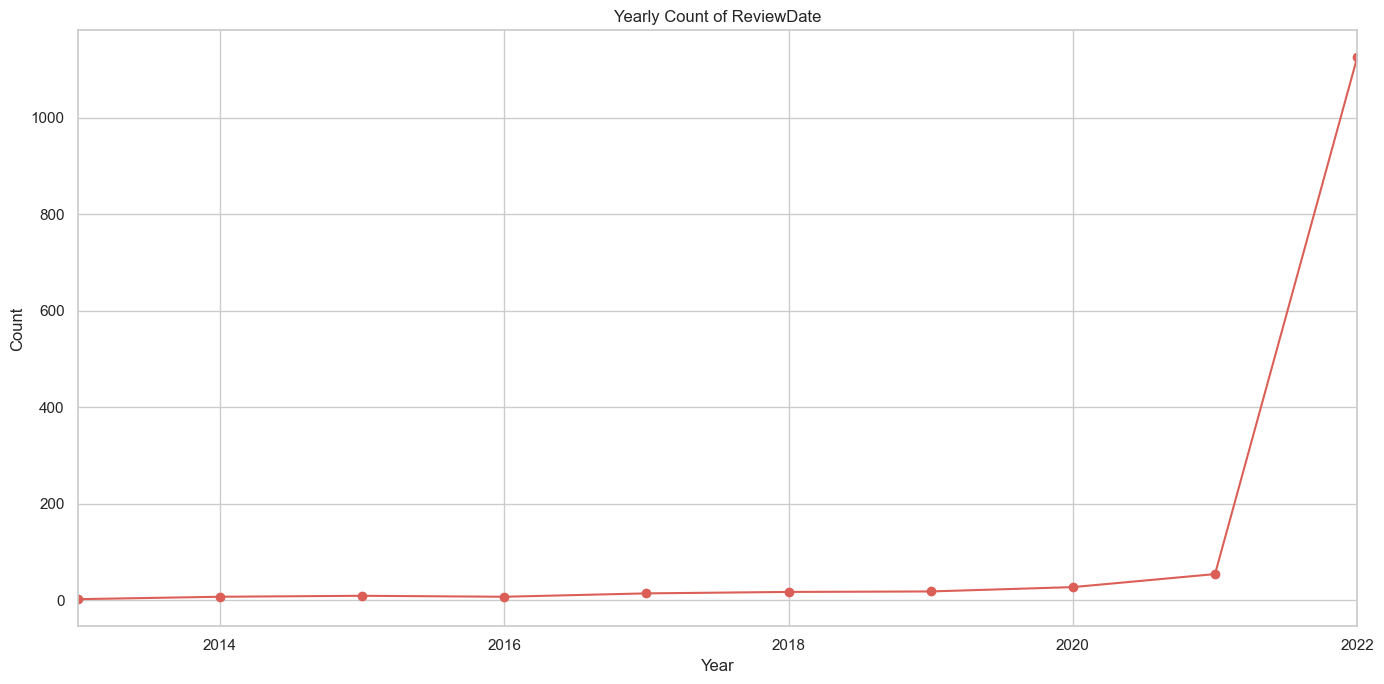

In [79]:
df2 = df_with_reviews
dt_stats(df2, 'ReviewDate')

The graph shows a dramatic increase in review counts in 2022, jumping from only 54 reviews in 2021 to over 1,100. This suggests that reviews are not conducted for every employee every year. Possible explanations include a backlog of delayed reviews due to external factors, a company-wide review initiative in 2022, or changes in recording methods. The low number of reviews in prior years indicates that reviews may only occur at specific milestones, such as after a set tenure or prior to an employee leaving.

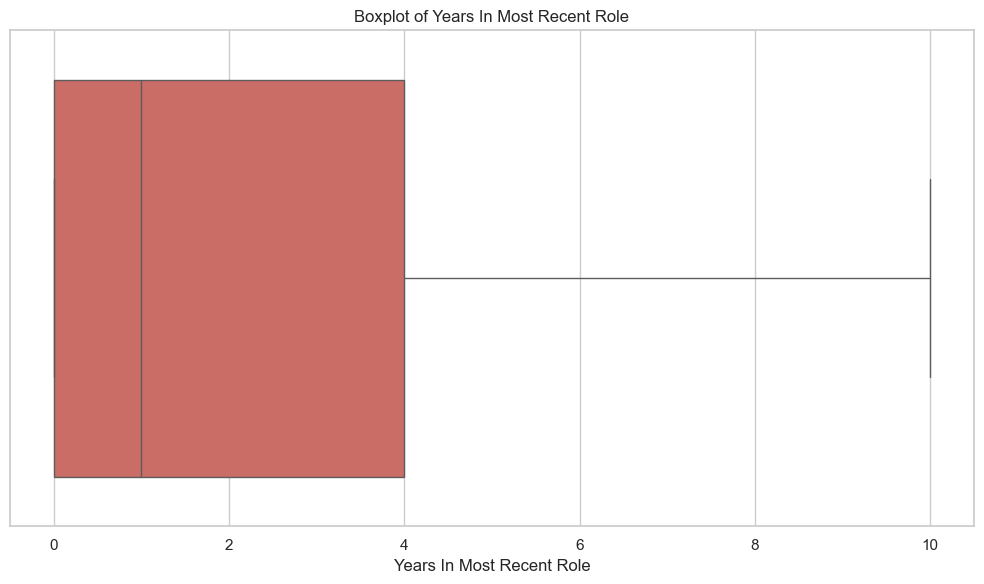


--- Numerical Summary: Years In Most Recent ---
count    1470.000000
mean        2.293197
std         2.539093
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        10.000000
Name: YearsInMostRecentRole, dtype: float64

Mode: 0
Skewness: 1.09
Kurtosis: 0.31


In [80]:
sns.boxplot(x=df['YearsInMostRecentRole'])
plt.title("Boxplot of Years In Most Recent Role")
plt.xlabel('Years In Most Recent Role')
plt.tight_layout()
plt.show()

# summary
print("\n--- Numerical Summary: Years In Most Recent ---")
desc = df['YearsInMostRecentRole'].describe()
print(desc)

# mode
print(f"\nMode: {df['YearsInMostRecentRole'].mode()[0]}") 
# skewness + kurtosis
print(f"Skewness: {skew(df['YearsInMostRecentRole'].dropna()):.2f}")
print(f"Kurtosis: {kurtosis(df['YearsInMostRecentRole'].dropna()):.2f}")

The boxplot is heavily right-skewed, with a long tail end, indicating that the amount of years an employee has stayed in their most recent role is on the low end, where 75% of the company have stayed in their current role for under 4 years. Furthermore, half of the company (50%) have only stayed in their recent role for under a year. It suggests that there might've been a huge structural change in the past few years. 

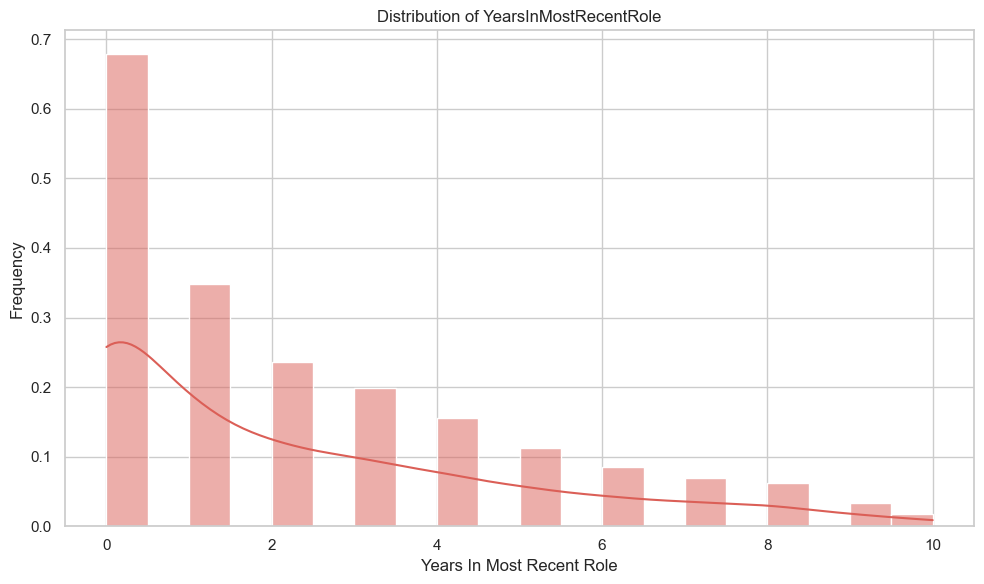

In [81]:
sns.histplot(df['YearsInMostRecentRole'], kde=True, stat='density', bins=20)
plt.title("Distribution of YearsInMostRecentRole")
plt.xlabel('Years In Most Recent Role')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The histogram also confirms that the number of employees who have stayed in their current role steadily decreases as the amount of years increase. It indicates that either the employees who would've stayed their the longest, had already left, or knowing that there was a big amount of hires in 2022, it could just represent a young workforce.

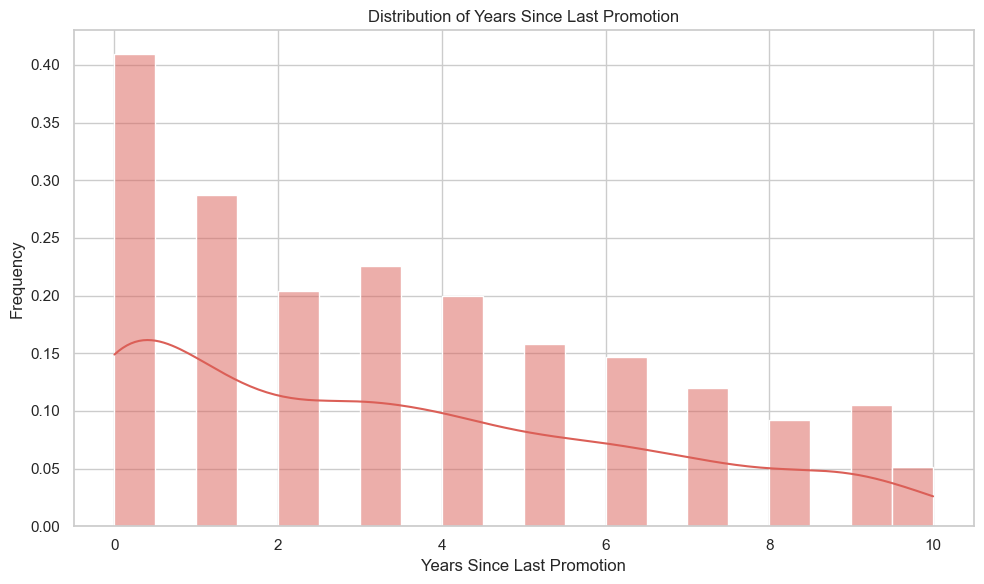

In [82]:
sns.histplot(df['YearsSinceLastPromotion'], kde=True, stat='density', bins=20)
plt.title("Distribution of Years Since Last Promotion")
plt.xlabel('Years Since Last Promotion')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Also related to **YearsInMostRecentRole**, we can see a similar pattern where most employees have only gone through 0-2 years out from their last promotion. This strongly implies that the **YearsInMostRecentRole** is influenced by recent promotions, rather than due to quick turnover.

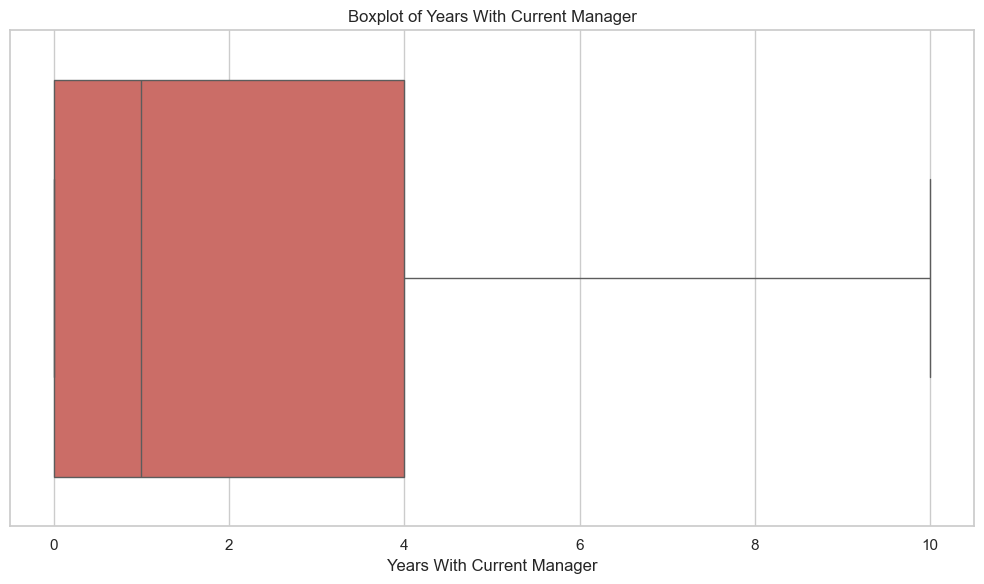

In [83]:
sns.boxplot(x=df['YearsWithCurrManager'])
plt.title("Boxplot of Years With Current Manager")
plt.xlabel('Years With Current Manager')
plt.tight_layout()
plt.show()

Similar with **YearsSinceLastPromotion**, the boxplot for **YearsWithCurrManager** shows the same trend: right-skewed with most of the data crowding between years 0-4. It further points out promotions, recent role and managerial changes are correlated with each other.


--- Categorical Summary: JobSatisfaction ---
                   Count  Percentages
JobSatisfaction                      
Neutral              337        26.33
Satisfied            336        26.25
Dissatisfied         300        23.44
Very Satisfied       261        20.39
Very Dissatisfied     46         3.59
Unique categories: 5
Most frequent: Neutral


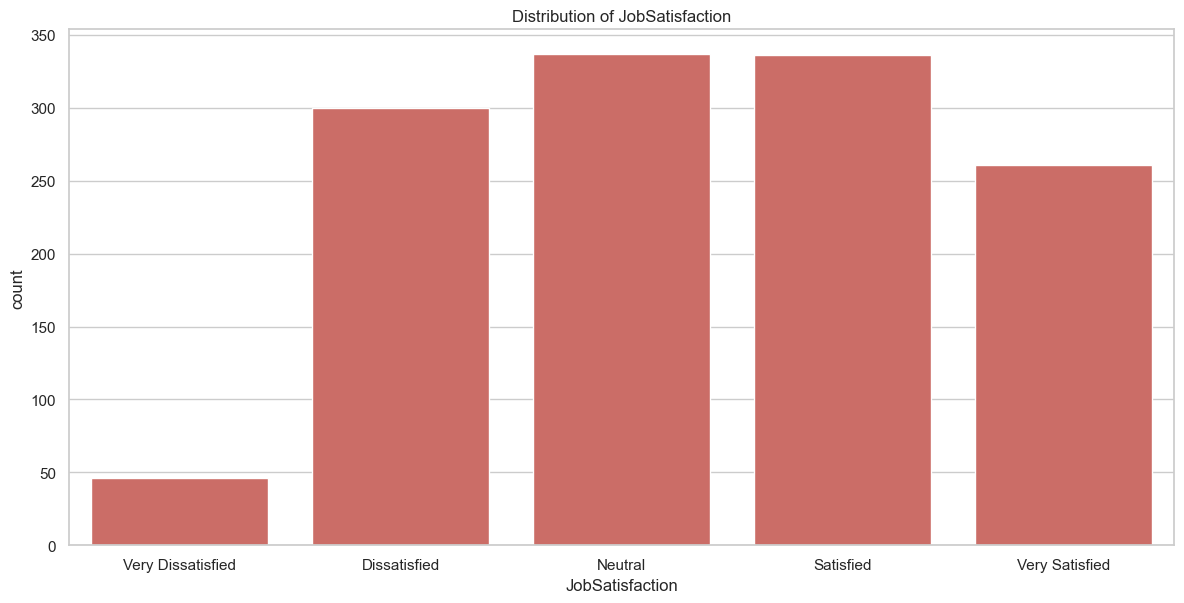

In [84]:
ql_stats(df2, 'JobSatisfaction')

Employees who have been reviewed show a varied sentiment towards Job Satisfaction. The most common responses are Neutral (26.33%) and Satisfied (26.25%), followed by Dissatisfied (23.44%) and Very Satisfied (20.39%). Only 3.59% of employees reported being Very Dissatisfied. This relatively balanced spread suggests that job satisfaction by itself may not be a strong predictor of attrition, since employees remain at the company despite mixed satisfaction levels. 


--- Categorical Summary: SelfRating ---
                     Count  Percentages
SelfRating                             
Meets Expectations     448        35.00
Exceeds Expectation    444        34.69
Above and Beyond       388        30.31
Unacceptable             0         0.00
Needs Improvement        0         0.00
Unique categories: 3
Most frequent: Meets Expectations


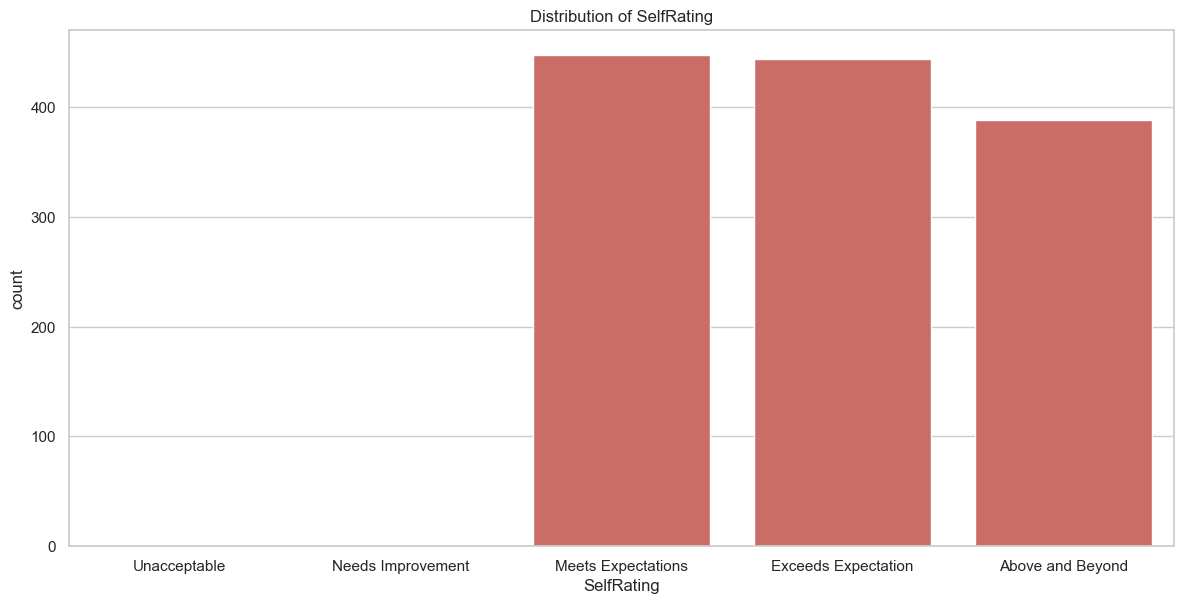

In [85]:
df2 = df_with_reviews
ql_stats(df2, 'SelfRating')

For Self Rating, employees seem to rate themselves on a range between Meets Expectations and Above and Beyond, showing a relatively positive outlook on their work performance. 0 employees rated themselves Unacceptable or Needs Improvement. The difference between the employees who rated themselves Above and Beyond and Exceeds Expectations is only 4.38%, which indicates that the proportion of employees in Self Rating is relatively balanced. 

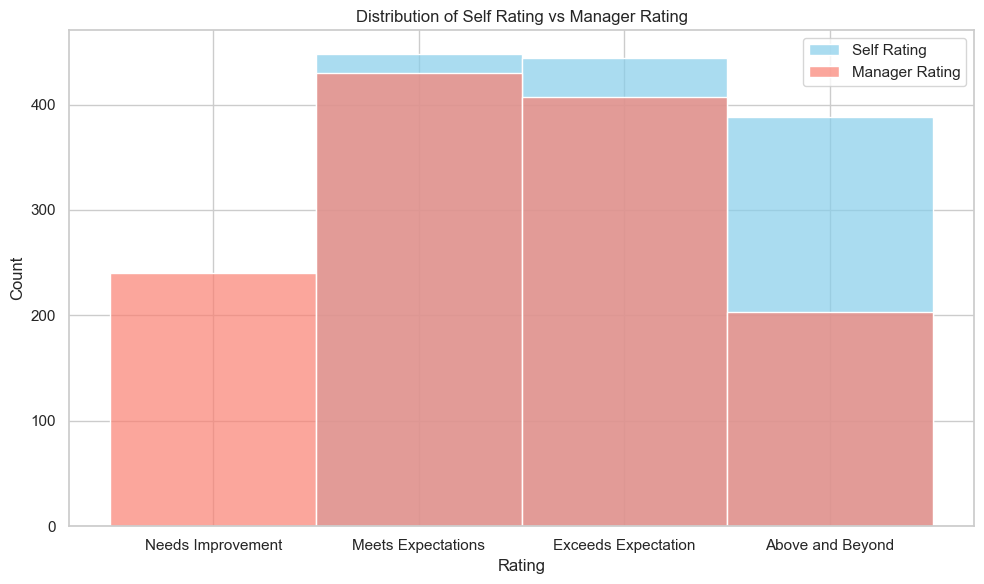


--- Categorical Summary: Manager Rating ---
                     Count  Percentages
ManagerRating                          
Meets Expectations     430        33.59
Exceeds Expectation    407        31.80
Needs Improvement      240        18.75
Above and Beyond       203        15.86
Unacceptable             0         0.00
Unique categories: 4
Most frequent: Meets Expectations


In [86]:
# plot distribution of SelfRating and ManagerRating for comparison
plt.figure(figsize=(10, 6))
sns.histplot(df2['SelfRating'], label='Self Rating', color='skyblue', stat='count', alpha=0.7, discrete=True)
sns.histplot(df2['ManagerRating'], label='Manager Rating', color='salmon', stat='count', alpha=0.7, discrete=True)
plt.title('Distribution of Self Rating vs Manager Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

counts = df2['ManagerRating'].value_counts(dropna=False)
percentages = df2['ManagerRating'].value_counts(normalize=True, dropna=False) * 100
print("\n--- Categorical Summary: Manager Rating ---")
summary = pd.DataFrame({
    'Count': counts,
    'Percentages': percentages.round(2)
})
print(summary)
print(f"Unique categories: {df2['ManagerRating'].nunique(dropna=False)}")
print(f"Most frequent: {df2['ManagerRating'].mode()[0]}")



In contrast with the Manager Rating, Managers seem to rate their employees more strict, with a lower percentage for a rating of Above and Beyond and a new 18.75% of employees who they rated Needs Improvement. No employees were rated an Unexceptable by their managers or themselves.

## Overall Findings
- The majority of employees are young, between 23 and 34 years old. 
- The salary range for all employees seem to center around $43,580 - $142,056, the low end of the spectrum.
- The company is most likely tech based, as 65.37% of employees work in the Technology Department.
- Recently (as of 2022), the company had an increase of 155 new employees, surpassing just slightly, the amount of employees they hired back in 2012.
- Most employees are in relatively new roles, with half of the company only being in their role for under a year. 
- Relating back to new roles, 0-2 years have passed since their last promotion for the majority of employees. 
- There was a drastic influx of reviews by the end of 2022, 1125 reviews were conducted, compared to 54 reviews in 2021.
- Job Satsifaction is relatively balanced across all employees, the rating that employees reported the most was Neutral (26.33%), the next highest rating being Satisfied (26.25%).
- Employees seem to highly regard their work performance, with all ratings falling between Meets Expectations and Above and Beyond.
- Managers are more strict towards work performance, stating that 18.75% of employees Need Improvement and only 15.86% of employees meeting Above and Beyond.

*Note: columns that were overall balanced or had fairly even proportions were not discussed here*

## 1. EDA - Bivariate Variables
Visualize and print out statistics for variables against Attrition

- Boxplots, pairplots, correlation heatmaps, Spearman's heatmap, stacked barplots, and line plots to help visualize correlation.


Statistics for Age by Attrition:
            count       mean       std   min   25%   50%   75%   max
Attrition                                                           
0          1233.0  29.460665  8.236182  18.0  23.0  27.0  35.0  51.0
1           237.0  26.540084  6.031299  18.0  22.0  26.0  29.0  48.0


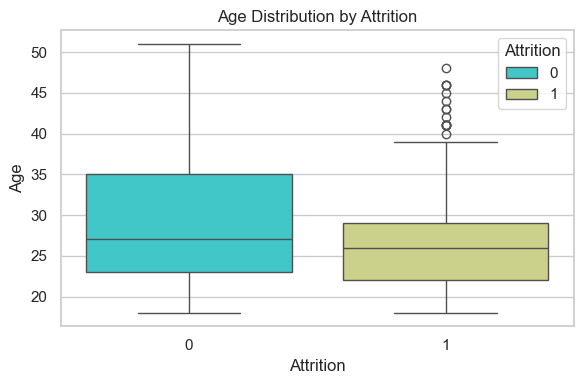

In [87]:
print("\nStatistics for Age by Attrition:")
print(df.groupby('Attrition')['Age'].describe())
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Attrition'], y=df['Age'], hue=df['Attrition'], palette='rainbow')
plt.title('Age Distribution by Attrition')
plt.tight_layout()
plt.show()
plt.close()

With Attrition=0 for employees who stayed and Attrition=1 for those who left, the boxplots show that the interquartile range (IQR) for employees who left is narrower, between 22–29 years. The mean and median are similar for both groups, differing by only 1–3 years. Both distributions are right-skewed, but employees who left have more outliers. The maximum age for employees who stayed is 51, while for those who left it is around 39, suggesting that younger employees are more likely to leave.

In [ ]:
group0 = df.loc[df['Attrition'] == 0, 'Age'].dropna()
group1 = df.loc[df['Attrition'] == 1, 'Age'].dropna()

alpha = 0.05
stat, p = stats.mannwhitneyu(group0, group1, alternative='two-sided')

print(f"Test: Mann-Whitney U")
print(f"Statistic/Corr: {stat:.4g}")
print(f"p_value: {p:.4g}")
print(f"Significance level: {alpha} ({(1-alpha)*100}% confidence)")
print(f"Null hypothesis (H0): There is no relationship/difference between Age and Attrition.")
print(f"Alternative hypothesis (Ha): There is a relationship/difference between Age and Attrition.")

if p < alpha:
        print(f"\nSince the p-value is less than {alpha}, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Age and Attrition.\n")
else:
    print(f"\nSince the p-value is greater than or equal to {alpha}, we fail to reject the null hypothesis and conclude that there is not enough evidence to say there is a statistically significant relationship/difference between Age and Attrition.\n")



Test: Mann-Whitney U
Statistic/Corr: 1.713e+05
p_value: 2.507e-05
Significance level: 0.05 (95% confidence)
Null hypothesis (H0): There is no relationship/difference between Age and Attrition.
Alternative hypothesis (Ha): There is a relationship/difference between Age and Attrition.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Age and Attrition.



After running the Mann-Whitney U Test, we see that there is a significant difference between Age and Attrition, which shows correlation.


Statistics for Salary by Attrition:
            count           mean            std      min      25%      50%  \
Attrition                                                                    
0          1233.0  118856.433090  105903.150384  20418.0  46388.0  75816.0   
1           237.0   82261.898734   82464.103025  20387.0  33273.0  50660.0   

                75%       max  
Attrition                      
0          152278.0  547204.0  
1           89771.0  539998.0  


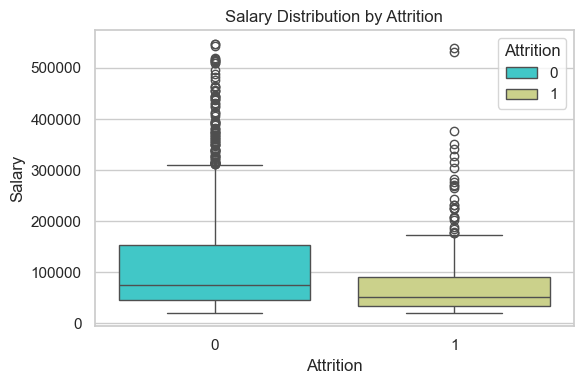

In [102]:
print("\nStatistics for Salary by Attrition:")
print(df.groupby('Attrition')['Salary'].describe())
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Attrition'], y=df['Salary'], hue=df['Attrition'], palette='rainbow')
plt.title('Salary Distribution by Attrition')
plt.tight_layout()
plt.show()
plt.close()

Similarly, the two boxplots for Salary against Attrition are both right-tailed, with the boxplot representing the employees left having a narrower IQR. Both of the boxplots also have numerous outliers. However, it does appear the salary for the employees who left does skew on the lower end. There is a possibility that a lower salary could drive employees to leave the company. 

In [106]:
group0 = df.loc[df['Attrition'] == 0, 'Salary'].dropna()
group1 = df.loc[df['Attrition'] == 1, 'Salary'].dropna()

alpha = 0.05
stat, p = stats.mannwhitneyu(group0, group1, alternative='two-sided')

print(f"Test: Mann-Whitney U")
print(f"Statistic/Corr: {stat:.4g}")
print(f"p_value: {p:.4g}")
print(f"Significance level: {alpha} ({(1-alpha)*100}% confidence)")
print(f"Null hypothesis (H0): There is no relationship/difference between Salary and Attrition.")
print(f"Alternative hypothesis (Ha): There is a relationship/difference between Salary and Attrition.")

if p < alpha:
        print(f"\nSince the p-value is less than {alpha}, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Salary and Attrition.\n")
else:
    print(f"\nSince the p-value is greater than or equal to {alpha}, we fail to reject the null hypothesis and conclude that there is not enough evidence to say there is a statistically significant relationship/difference between Salary and Attrition.\n")

Test: Mann-Whitney U
Statistic/Corr: 1.861e+05
p_value: 2.436e-11
Significance level: 0.05 (95.0% confidence)
Null hypothesis (H0): There is no relationship/difference between Salary and Attrition.
Alternative hypothesis (Ha): There is a relationship/difference between Salary and Attrition.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Salary and Attrition.



After running the Mann-Whitney U Test, we see that Salary and Attrition do indeed have a significant difference with each other.


Statistics for Years At Company by Attrition:
            count      mean       std  min  25%  50%  75%   max
Attrition                                                      
0          1233.0  4.973236  3.266332  0.0  2.0  5.0  8.0  10.0
1           237.0  2.426160  2.476977  0.0  0.0  1.0  4.0  10.0


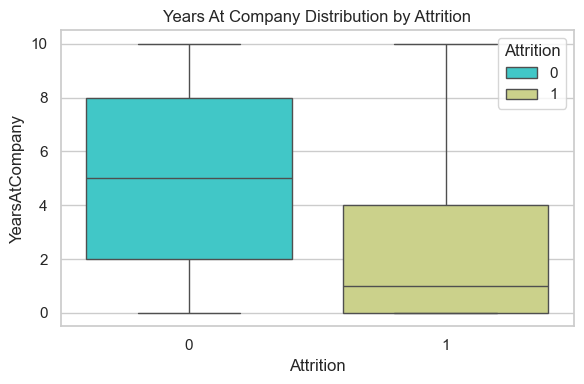

In [90]:
print("\nStatistics for Years At Company by Attrition:")
print(df.groupby('Attrition')['YearsAtCompany'].describe())
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Attrition'], y=df['YearsAtCompany'], hue=df['Attrition'], palette='rainbow')
plt.title('Years At Company Distribution by Attrition')
plt.tight_layout()
plt.show()
plt.close()

While tenure for the employees that stayed, looks relatively centered, the other boxplot looks right-skewed. More specifically, 75% of the employees that left only spent less than 4 years at the company. It indicates that there's a higher turnover rate for employees who are near the 3rd or 4th year of tenure. 

In [107]:
group0 = df.loc[df['Attrition'] == 0, 'YearsAtCompany'].dropna()
group1 = df.loc[df['Attrition'] == 1, 'YearsAtCompany'].dropna()

alpha = 0.05
stat, p = stats.mannwhitneyu(group0, group1, alternative='two-sided')

print(f"Test: Mann-Whitney U")
print(f"Statistic/Corr: {stat:.4g}")
print(f"p_value: {p:.4g}")
print(f"Significance level: {alpha} ({(1-alpha)*100}% confidence)")
print(f"Null hypothesis (H0): There is no relationship/difference between Years At Company and Attrition.")
print(f"Alternative hypothesis (Ha): There is a relationship/difference between Years At Company and Attrition.")

if p < alpha:
        print(f"\nSince the p-value is less than {alpha}, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Years At Company and Attrition.\n")
else:
    print(f"\nSince the p-value is greater than or equal to {alpha}, we fail to reject the null hypothesis and conclude that there is not enough evidence to say there is a statistically significant relationship/difference between Years At Company and Attrition.\n")

Test: Mann-Whitney U
Statistic/Corr: 2.118e+05
p_value: 2.883e-28
Significance level: 0.05 (95.0% confidence)
Null hypothesis (H0): There is no relationship/difference between Years At Company and Attrition.
Alternative hypothesis (Ha): There is a relationship/difference between Years At Company and Attrition.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Years At Company and Attrition.



The Mann-Whitney U Test confirms that there is a difference between Years At Company and Attrition. 


Statistics for Years In Most Recent Role by Attrition:
            count      mean       std  min  25%  50%  75%   max
Attrition                                                      
0          1233.0  2.543390  2.600563  0.0  0.0  2.0  4.0  10.0
1           237.0  0.991561  1.672285  0.0  0.0  0.0  1.0   8.0


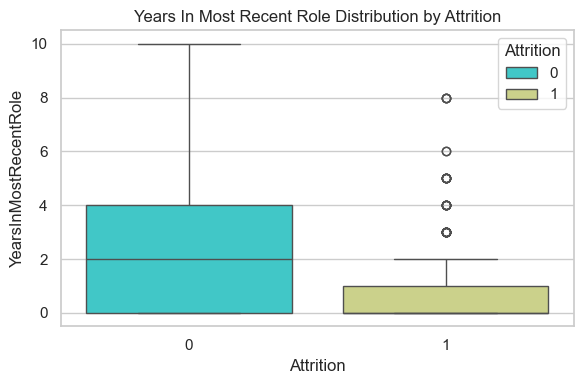

In [91]:
print("\nStatistics for Years In Most Recent Role by Attrition:")
print(df.groupby('Attrition')['YearsInMostRecentRole'].describe())
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Attrition'], y=df['YearsInMostRecentRole'], hue=df['Attrition'], palette='rainbow')
plt.title('Years In Most Recent Role Distribution by Attrition')
plt.tight_layout()
plt.show()
plt.close()

The boxplots for the Years In Most Recent Role is interesting because it shows that 75% of the employees that left, only spent less than under a year in their last role before leaving. The employees who have spent more than a year in their last role before leaving, are outliers and are considered extreme cases. 

In [ ]:
group0 = df.loc[df['Attrition'] == 0, 'YearsInMostRecentRole'].dropna()
group1 = df.loc[df['Attrition'] == 1, 'YearsInMostRecentRole'].dropna()

alpha = 0.05
stat, p = stats.mannwhitneyu(group0, group1, alternative='two-sided')

print(f"Test: Mann-Whitney U")
print(f"Statistic/Corr: {stat:.4g}")
print(f"p_value: {p:.4g}")
print(f"Significance level: {alpha} ({(1-alpha)*100}% confidence)")
print(f"Null hypothesis (H0): There is no relationship/difference between Years In Most Recent Role and Attrition.")
print(f"Alternative hypothesis (Ha): There is a relationship/difference between Years In Most Recent Role and Attrition.")

if p < alpha:
        print(f"\nSince the p-value is less than {alpha}, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Years In Most Recent Role and Attrition.\n")
else:
    print(f"\nSince the p-value is greater than or equal to {alpha}, we fail to reject the null hypothesis and conclude that there is not enough evidence to say there is a statistically significant relationship/difference between Years In Most Recent Role and Attrition.\n")

The Mann-Whitney U Test confirms that there is a difference between Years In Most Recent Role and Attrition.


Statistics for Years Since Last Promotion by Attrition:
            count      mean       std  min  25%  50%  75%   max
Attrition                                                      
0          1233.0  3.824818  2.935751  0.0  1.0  3.0  6.0  10.0
1           237.0  1.443038  2.054842  0.0  0.0  1.0  2.0   9.0


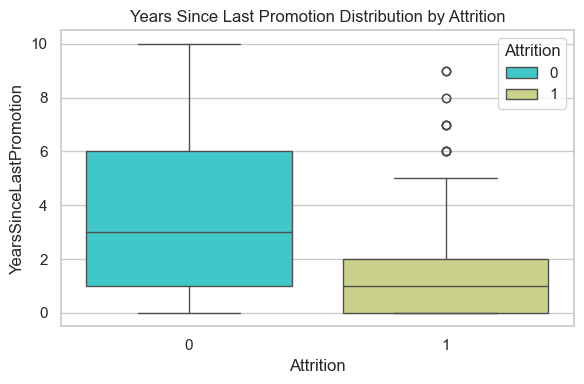

In [108]:
print("\nStatistics for Years Since Last Promotion by Attrition:")
print(df.groupby('Attrition')['YearsSinceLastPromotion'].describe())
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Attrition'], y=df['YearsSinceLastPromotion'], hue=df['Attrition'], palette='rainbow')
plt.title('Years Since Last Promotion Distribution by Attrition')
plt.tight_layout()
plt.show()
plt.close()


Statistics for Business Travel by Attrition:
Attrition             0    1
BusinessTravel              
Frequent Traveller  208   69
No Travel           138   12
Some Travel         887  156


/var/folders/m4/yjvjdcbn13v_8w2jnkcpn2jr0000gn/T/ipykernel_77640/1892242102.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('BusinessTravel')['Attrition'].value_counts().unstack().fillna(0))


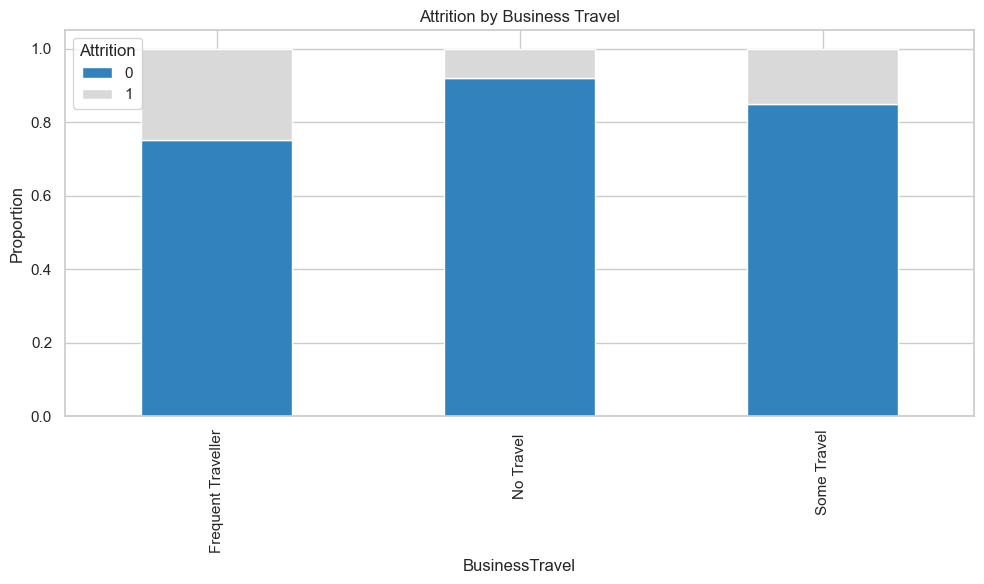

In [ ]:
print("\nStatistics for Business Travel by Attrition:")
print(df.groupby('BusinessTravel')['Attrition'].value_counts().unstack().fillna(0))
cross_tab = pd.crosstab(df['BusinessTravel'], df['Attrition'])
cross_tab_pct = cross_tab.div(cross_tab.sum(1), axis=0)
cross_tab_pct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20c')
plt.ylabel('Proportion')
plt.title('Attrition by Business Travel')
plt.legend(title='Attrition')
plt.tight_layout()
plt.show()
plt.close()

The proportion of employees who stayed/left is relatively similar across all categories, but for the employees who have frequently traveled for business have the highest rate of attrition (4.69%).


Statistics for Education Field by Attrition:
Attrition              0   1
EducationField              
Business Studies      74  20
Computer Science     381  59
Economics             85  16
Human Resources       20   7
Information Systems  316  47
Marketing            260  65
Other                 71  11
Technical Degree      26  12


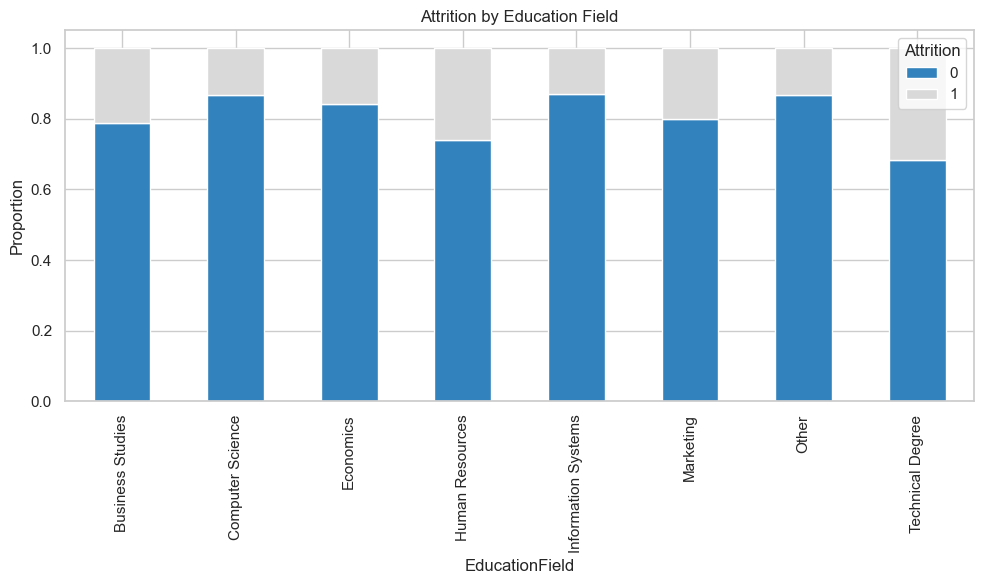

In [95]:
print("\nStatistics for Education Field by Attrition:")
print(df.groupby('EducationField')['Attrition'].value_counts().unstack().fillna(0))
cross_tab = pd.crosstab(df['EducationField'], df['Attrition'])
cross_tab_pct = cross_tab.div(cross_tab.sum(1), axis=0)
cross_tab_pct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20c')
plt.ylabel('Proportion')
plt.title('Attrition by Education Field')
plt.legend(title='Attrition')
plt.tight_layout()
plt.show()
plt.close()

For Education Fields, the proportion of employees for attrition stays relatively similar as well, except for employees who have a technical degree. Specifically, 12 out of 38 employees (31.58%) who hold technical degrees have left the company. In contrast, the employees who studied in Information Systems have the highest rate of retention (87.05%). 